Project CPS 840 
Awale Hassan - 500704868
Shiqi Dong - 


The goal of this machine learning project is to import a dataset from Kaggle of Steam users and their video game library, compare these users with others and create a recomended game (that they have not already purchased) for them based on similar prefences.

First steps is dealing with the raw data and pruning features. The initial format of the data set was as very different from the final data set we utilized. Come columns, not useful to us for our algorithm, had to be removed entirley.


In [60]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from ast import literal_eval

data1=pd.read_csv('steam-200k.csv', low_memory=False) #importing data set
data2 = pd.read_csv('Steam_games.csv')  #supporting data set with steam game prices, to be cross refrenced for recomendation
data1=data1.rename(columns = {'The Elder Scrolls V Skyrim':'game'}) #renaming columns to appropriate tittles
data1=data1.rename(columns = {'151603712':'user'}) 
data1=data1.rename(columns = {'1.0':'playtime'})
data1=data1.rename(columns = {'purchase':'status'})


# here we removed the purchase column, but kept the information that it contains. This was done by combining it with the playtime column. 
#Now, users will no longer have an entry for both the purchase and playing a game, they will only have one single row. 
#Where as before, users would have one row entry for purchasing a game, and one row for actually playing it,
#now if a user has less than an hour of playtime, then they have only purchased a game, but not played it.

data1.playtime = data1.playtime + 1
data1 = data1[(data1.status != 'purchase')]
del data1['status']
del data1['0']
data1['game'] = data1['game'].str.lower()


#Creating a list of all games
gameList = []
for gamename in data1['game']:
    if not(gamename in gameList):
        gameList.append(gamename)

gameList.insert(0,'users') 
gameList.append('0') 

#creating a list of all users
userList = []
for user in data1['user']:
    if not(user in userList):
        userList.append(user)



#translating the games into a dictionary matched to numbers, so that the dataset can replace the game strings with numbers
#This allows us to transform the dataset into an array, easier to manipulate
gameDictionary = {k: v for v, k in enumerate(gameList)}

 
gameDictionary
len(userList)

11350

In [32]:
#crearing a new matrix, and filling it with the useful information from the initial dataset
#users will be the first column, numbers translating to games will be the first row
#individual cells will contain playtime for a specific user to a specific game
#eg gameMatrix[x][y] will contain the play time for user gameMatrix[0][y] for the game gameMatrix[x][0]

gameMatrix = np.zeros((len(userList)+1,len(gameList)+1))
gameMatrix[1][:] = range(0,len(gameList)+1)
i = 1
for user in userList:
    gameMatrix[i][0] = user
    i=i+1

checkUniqeUser = 151603712
userIndex=1
gameNumMatch = 0
for index, row in data1.iterrows():
    if not(row.user == checkUniqeUser):
        if not(userIndex == 11349):
            userIndex=userIndex+1
    gameNumMatch = gameDictionary[row.game]
    gameMatrix[userIndex][gameNumMatch] = row.playtime

gameMatrix[1][1]
print(len(gameList))

3602


In [49]:
#Our next step is a reduction in dimensionality. 
#As it currently stands, each and every single game in our list is treated as a single feature for users
#This is very, very bad, as there are over 3600 games. So our users need their dimensions reduced to a usable size. 
from matplotlib.mlab import PCA
import warnings
warnings.filterwarnings("ignore")
results = PCA(gameMatrix)

In [61]:
#Now that our data is sufficiently pruned, the ideal algorithm to use here would be K Nearest Neighbor
#For any user we would like to recomend, we would find other users with similar libraries and play time in similar games
#These would be our nearest neighbors. From there, we would find a game with substantial playtime that our nearest neighbors own, but the initial user does not

gameMatrix.shape

(11351, 3603)

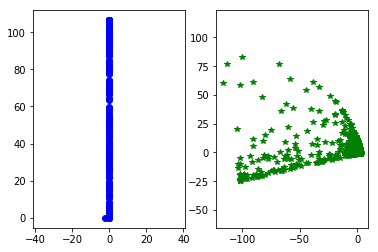

In [53]:
# THIS CODE IS FROM THE WEBSITE THE GLOWING PYTHON, ALL RIGHTS BELONG TO THEM
#https://glowingpython.blogspot.com/2011/07/principal-component-analysis-with-numpy.html
#Here we utilize their algorithm to reduce the demonsionality of our data. 
from numpy import mean,cov,double,cumsum,dot,linalg,array,rank
from pylab import plot,subplot,axis,stem,show,figure

def princomp(A):
 """ performs principal components analysis 
     (PCA) on the n-by-p data matrix A
     Rows of A correspond to observations, columns to variables. 

 Returns :  
  coeff :
    is a p-by-p matrix, each column containing coefficients 
    for one principal component.
  score : 
    the principal component scores; that is, the representation 
    of A in the principal component space. Rows of SCORE 
    correspond to observations, columns to components.
  latent : 
    a vector containing the eigenvalues 
    of the covariance matrix of A.
 """
 # computing eigenvalues and eigenvectors of covariance matrix
 M = (A-mean(A.T,axis=1)).T # subtract the mean (along columns)
 [latent,coeff] = linalg.eig(cov(M)) # attention:not always sorted
 score = dot(coeff.T,M) # projection of the data in the new space
 return coeff,score,latent

coeff, score, latent = princomp(gameMatrix.T)

figure()
subplot(121)
# every eigenvector describe the direction
# of a principal component.
m = mean(gameMatrix,axis=1)
plot([0, -coeff[0,0]*2]+m[0], [0, -coeff[0,1]*2]+m[1],'--k')
plot([0, coeff[1,0]*2]+m[0], [0, coeff[1,1]*2]+m[1],'--k')
plot(gameMatrix[0,:],gameMatrix[1,:],'ob') # the data
axis('equal')
subplot(122)
# new data
plot(score[0,:],score[1,:],'*g')
axis('equal')
show()

In [63]:
gameMatrix.shape
score.shape


(11351, 3603)

In [65]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(gameMatrix)
distances, indices = nbrs.kneighbors(gameMatrix)

indices  

array([[    0,  7718],
       [    1, 11349],
       [    2,   805],
       ...,
       [11348,  3496],
       [11349,  8480],
       [11350,  4354]])

In [68]:
distances

array([[0.00000000e+00, 1.22904431e-02],
       [0.00000000e+00, 6.20937811e+03],
       [0.00000000e+00, 6.41273353e-03],
       ...,
       [0.00000000e+00, 9.83743371e-01],
       [0.00000000e+00, 3.79624136e+02],
       [0.00000000e+00, 9.06617908e-03]])